In [1]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.1')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [20]:
# DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
# data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
# df = data[["cont_africa", "rugged", "rgdppc_2000"]]
# df = df[np.isfinite(df.rgdppc_2000)]
# df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
# df

cluster_candidates = pd.read_csv('../PleiadesTidalTails/data/clean.csv')
del cluster_candidates['Unnamed: 0']
ra_mean = np.median(cluster_candidates['ra'])
dec_mean = np.median(cluster_candidates['dec'])
pmra_mean = np.median(cluster_candidates['pmra'])
pmdec_mean = np.median(cluster_candidates['pmdec'])

cluster_candidates['angular_distance'] = np.sqrt((cluster_candidates['ra'] - ra_mean)**2 + (cluster_candidates['dec'] - dec_mean)**2)
cluster_candidates['pm_relative'] = np.sqrt((cluster_candidates['pmra'] - pmra_mean)**2 + (cluster_candidates['pmdec'] - pmdec_mean)**2)

# scaler_astrometry = StandardScaler()
# scaler_rv = StandardScaler()

# cluster_candidates[['ra','dec','pmra','pmdec','parallax']] = scaler_astrometry.fit_transform(cluster_candidates[['ra','dec','pmra','pmdec','parallax']])
# #cluster_candidates[['l','b','pmra','pmdec','parallax']] = scaler_astrometry.fit_transform(cluster_candidates[['l','b','pmra','pmdec','parallax']])
# #cluster_candidates[['radial_velocity','radial_velocity_error']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity','radial_velocity_error']])
# cluster_candidates[['radial_velocity']] = scaler_rv.fit_transform(cluster_candidates[['radial_velocity']])

print(len(cluster_candidates))

cluster_candidates_rv = cluster_candidates[~cluster_candidates['radial_velocity'].isna()]
#cluster_candidates_rv = cluster_candidates_rv[~cluster_candidates_rv['radial_velocity_error'].isna()]
print(len(cluster_candidates_rv))
cluster_candidates_rv = cluster_candidates_rv[(np.abs(cluster_candidates_rv['radial_velocity']) <= 0.25*np.std(cluster_candidates_rv['radial_velocity']))]
cluster_candidates_rv.info()

1502
509
<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 0 to 1494
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   level_0                     373 non-null    int64  
 1   index                       373 non-null    int64  
 2   source_id                   373 non-null    int64  
 3   ra                          373 non-null    float64
 4   ra_error                    373 non-null    float64
 5   dec                         373 non-null    float64
 6   dec_error                   373 non-null    float64
 7   l                           373 non-null    float64
 8   b                           373 non-null    float64
 9   parallax                    373 non-null    float64
 10  parallax_error              373 non-null    float64
 11  pmra                        373 non-null    float64
 12  pmra_error                  373 non-null    float64
 13  pmdec                       37

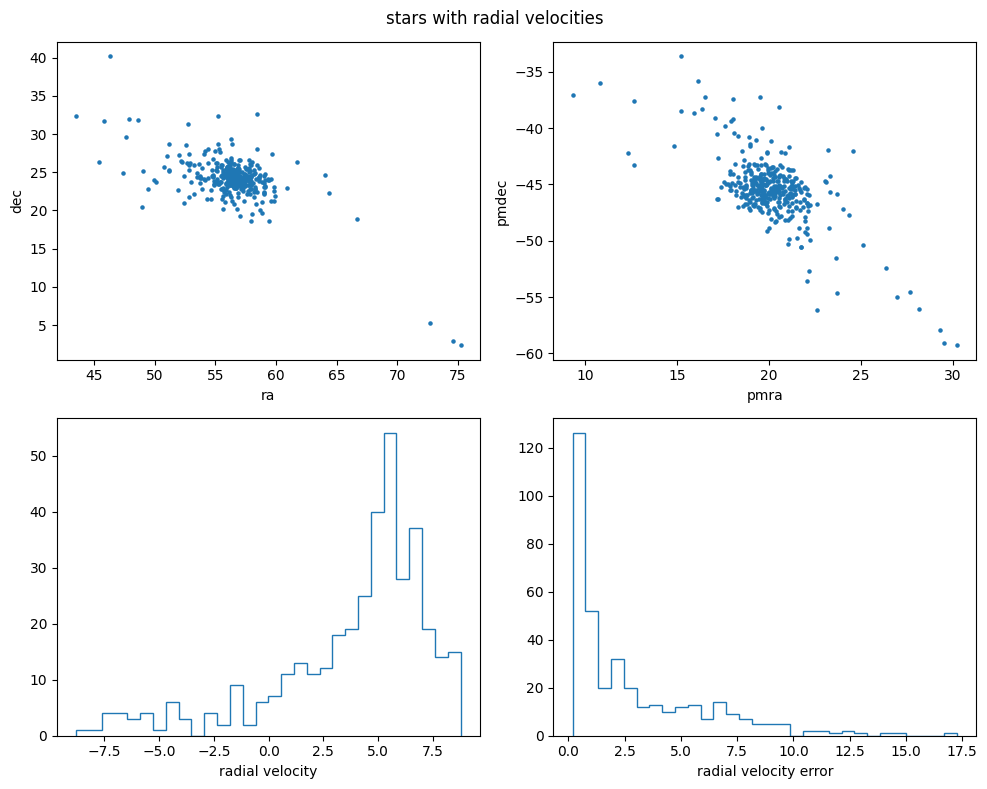

In [21]:
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
# african_nations = df[df["cont_africa"] == 1]
# non_african_nations = df[df["cont_africa"] == 0]

# sns.scatterplot(x=non_african_nations["rugged"], y=non_african_nations["rgdppc_2000"], ax=ax[0])
# ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

# sns.scatterplot(x=african_nations["rugged"], y=african_nations["rgdppc_2000"], ax=ax[1])
# ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations")
# plt.show()

fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('stars with radial velocities')

ax[0,0].scatter(cluster_candidates_rv['ra'], cluster_candidates_rv['dec'], s=5)
ax[0,0].set_xlabel('ra')
ax[0,0].set_ylabel('dec')

ax[0,1].scatter(cluster_candidates_rv['pmra'], cluster_candidates_rv['pmdec'], s=5)
ax[0,1].set_xlabel('pmra')
ax[0,1].set_ylabel('pmdec')

ax[1,0].hist(cluster_candidates_rv['radial_velocity'], bins=30, density=False, histtype='step')
ax[1,0].set_xlabel('radial velocity')

ax[1,1].hist(cluster_candidates_rv['radial_velocity_error'], bins=30, histtype='step', density=False)
ax[1,1].set_xlabel('radial velocity error')
fig.tight_layout()
plt.show()

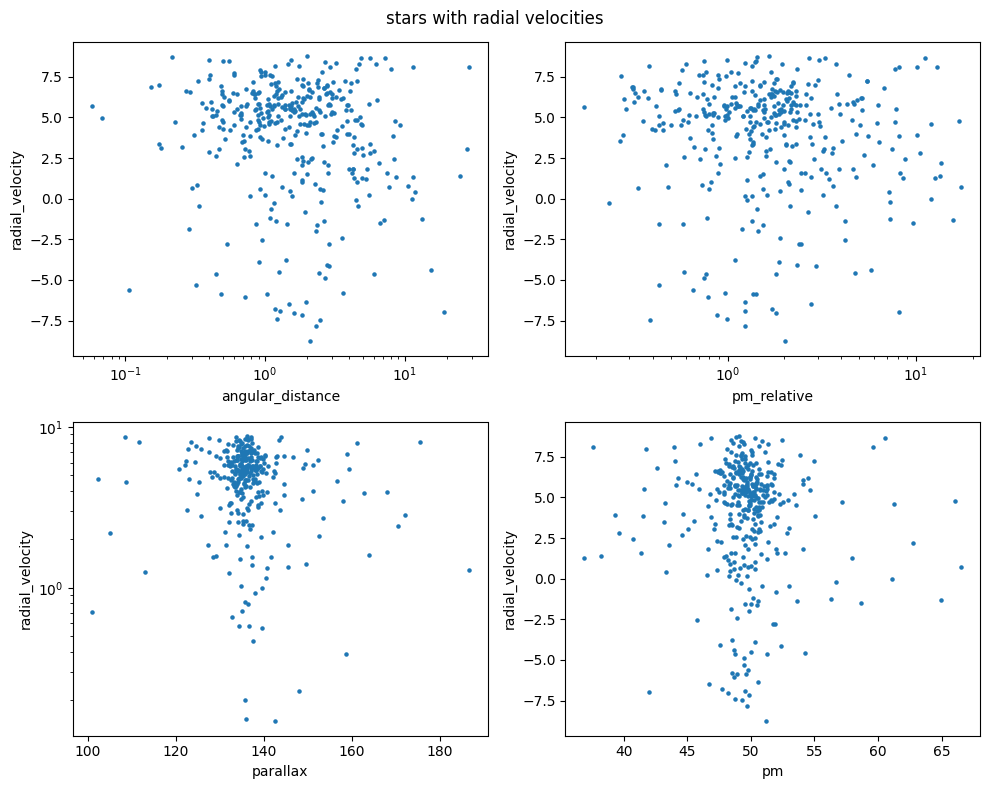

In [34]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

fig.suptitle('stars with radial velocities')

ax[0,0].scatter(cluster_candidates_rv['angular_distance'], cluster_candidates_rv['radial_velocity'], s=5)
ax[0,0].set_xlabel('angular_distance')
ax[0,0].set_ylabel('radial_velocity')
ax[0,0].set_xscale('log')

ax[0,1].scatter(cluster_candidates_rv['pm_relative'], cluster_candidates_rv['radial_velocity'], s=5)
ax[0,1].set_xlabel('pm_relative')
ax[0,1].set_ylabel('radial_velocity')
ax[0,1].set_xscale('log')

ax[1,0].scatter(1000/cluster_candidates_rv['parallax'], cluster_candidates_rv['radial_velocity'], s=5)
ax[1,0].set_xlabel('parallax')
ax[1,0].set_ylabel('radial_velocity')
ax[1,0].set_yscale('log')

ax[1,1].scatter(np.sqrt(cluster_candidates_rv['pmra']**2 + cluster_candidates_rv['pmdec']**2), cluster_candidates_rv['radial_velocity'], s=5)
ax[1,1].set_xlabel('pm')
ax[1,1].set_ylabel('radial_velocity')
fig.tight_layout()
plt.show()

# Linear Regression

In [35]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)


# Training with PyTorch Optimizers

In [36]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
# df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
# df
cluster_candidates_rv.keys()

Index(['level_0', 'index', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error',
       'l', 'b', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_rp_mean_mag',
       'phot_bp_mean_mag', 'radial_velocity', 'radial_velocity_error', 'ruwe',
       'ag_gspphot', 'ebpminrp_gspphot', 'nu_eff_used_in_astrometry',
       'pseudocolour', 'ecl_lat', 'ecl_lon', 'astrometric_params_solved',
       'v_parallel_obs_field', 'v_perpendicular_obs_field',
       'v_parallel_pred_field', 'v_perpendicular_pred_field',
       'delta_v_parallel', 'x_candidates', 'y_candidates', 'z_candidates',
       'maha', 'v_ra', 'v_dec', 'distance', 'angular_distance', 'pm_relative'],
      dtype='object')

In [37]:
#data = torch.tensor(df[["cont_africa","rugged","cont_africa_x_rugged","rgdppc_2000"]].values, dtype=torch.float)
#data = torch.tensor(cluster_candidates_rv[["ra","dec","pmra","pmdec","parallax","radial_velocity"]].values, dtype=torch.float)
data = torch.tensor(cluster_candidates_rv[["pm_relative","angular_distance","radial_velocity"]].values, dtype=torch.float)
x_data, y_data = data[:,:-1], data[:,-1]

x_data.shape, y_data.shape

(torch.Size([373, 2]), torch.Size([373]))

In [38]:
# Regression model
linear_reg_model = PyroModule[nn.Linear](2, 1)

# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.01)
num_iterations = 50000 if not smoke_test else 2

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 7356.9507
[iteration 0100] loss: 6795.4434
[iteration 0150] loss: 6361.1689
[iteration 0200] loss: 6007.5078
[iteration 0250] loss: 5726.1670
[iteration 0300] loss: 5504.7744
[iteration 0350] loss: 5333.0679
[iteration 0400] loss: 5202.5674
[iteration 0450] loss: 5105.7041
[iteration 0500] loss: 5035.6001
[iteration 0550] loss: 4986.1621
[iteration 0600] loss: 4952.2075
[iteration 0650] loss: 4929.5039
[iteration 0700] loss: 4914.7310
[iteration 0750] loss: 4905.3779
[iteration 0800] loss: 4899.6196
[iteration 0850] loss: 4896.1719
[iteration 0900] loss: 4894.1660
[iteration 0950] loss: 4893.0312
[iteration 1000] loss: 4892.4077
[iteration 1050] loss: 4892.0757
[iteration 1100] loss: 4891.9033
[iteration 1150] loss: 4891.8164
[iteration 1200] loss: 4891.7744
[iteration 1250] loss: 4891.7549
[iteration 1300] loss: 4891.7451
[iteration 1350] loss: 4891.7412
[iteration 1400] loss: 4891.7393
[iteration 1450] loss: 4891.7388
[iteration 1500] loss: 4891.7383
[iteration

## Plotting the Regression Fit

In [23]:
# fit = df.copy()
# fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
# african_nations = fit[fit["cont_africa"] == 1]
# non_african_nations = fit[fit["cont_africa"] == 0]

# fig.suptitle("Regression Fit", fontsize=16)
# ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
# ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
# ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")
# ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
# ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
# ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [39]:
#prediction_train = preds_train['obs'].T.detach().numpy().mean(axis=1)
prediction_train = linear_reg_model(x_data).detach().cpu().numpy()
#prediction_test = preds_test['obs'].T.detach().numpy().mean(axis=1)

prediction_train.shape#, prediction_test.shape

(373, 1)

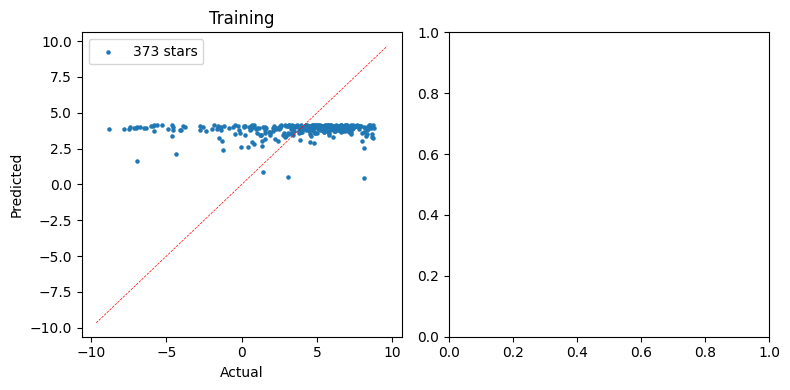

In [40]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

axes[0].scatter(y_data, prediction_train, s=5, label='%s stars'%len(y_data))
axes[0].set_xlabel("Actual", fontsize=10)
axes[0].set_ylabel("Predicted",  fontsize=10)
axes[0].set_title("Training")
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red', ls='--', lw=0.5)
axes[0].legend()

# axes[1].scatter(y_test, prediction_test, s=5, label='%s stars'%len(y_test))
# axes[1].set_xlabel("Actual", fontsize=10)
# axes[1].set_ylabel("Predicted",  fontsize=10)
# axes[1].set_title("Test")
# x = np.linspace(*axes[1].get_xlim())
# axes[1].plot(x, x, color='red', ls='--', lw=0.5)
# axes[1].legend()

fig.tight_layout()
plt.show()

#print('Train:',mean_absolute_error(y_train, prediction_train)) # train
#print('Test:',mean_absolute_error(y_test, prediction_test)) # test

# Bayesian Regression with Pyro’s Stochastic Variational Inference (SVI)

In [8]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [9]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [10]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [11]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 6.2310
[iteration 0101] loss: 3.5269
[iteration 0201] loss: 3.2377
[iteration 0301] loss: 3.0867
[iteration 0401] loss: 2.6374
[iteration 0501] loss: 2.0617
[iteration 0601] loss: 1.4856
[iteration 0701] loss: 1.4631
[iteration 0801] loss: 1.4632
[iteration 0901] loss: 1.4592
[iteration 1001] loss: 1.4939
[iteration 1101] loss: 1.4989
[iteration 1201] loss: 1.4937
[iteration 1301] loss: 1.4679
[iteration 1401] loss: 1.4581


In [12]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2371, -1.8097, -0.1691,  0.3790,  9.1824])
AutoDiagonalNormal.scale tensor([0.0552, 0.1143, 0.0387, 0.0769, 0.0700])


In [13]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.9327, 0.9647, 0.9976]),
 'linear.weight': tensor([[[-1.8868, -0.1952,  0.3272]],
 
         [[-1.8097, -0.1691,  0.3790]],
 
         [[-1.7325, -0.1430,  0.4309]]]),
 'linear.bias': tensor([[9.1351],
         [9.1824],
         [9.2296]])}

# Model evaluation

In [14]:
from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

predictive = Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [15]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

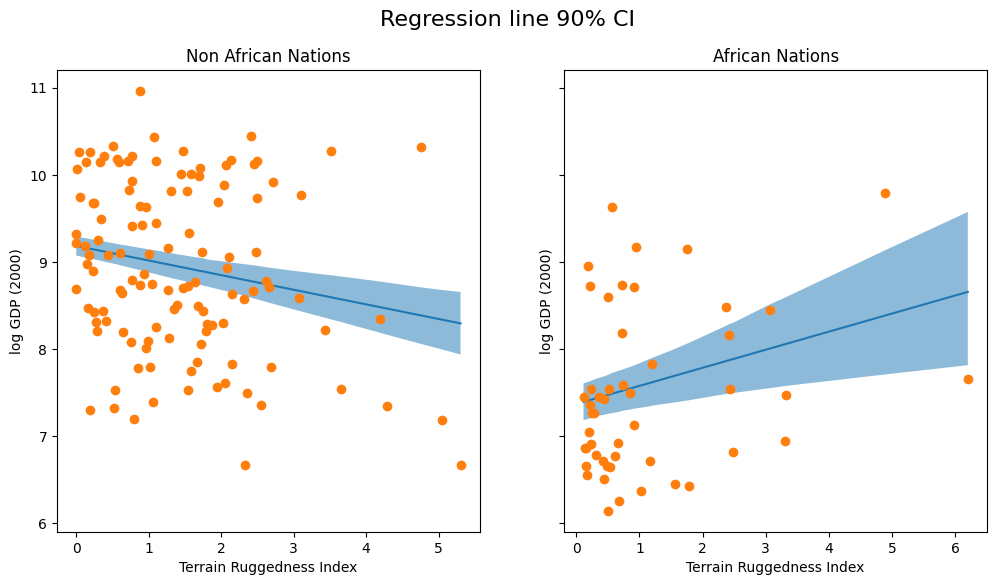

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

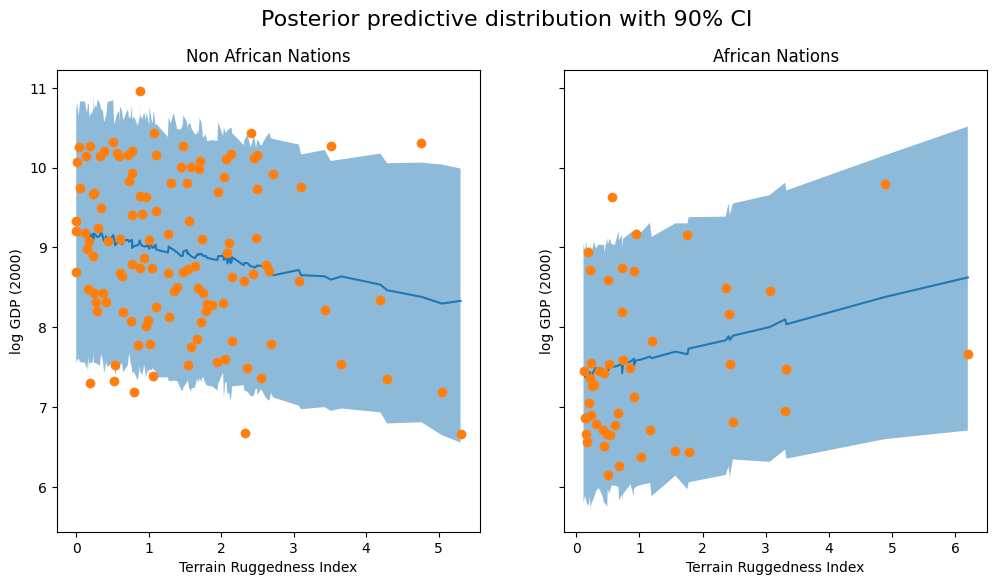

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

/tmp/ipykernel_32413/2694250413.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
/tmp/ipykernel_32413/2694250413.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})


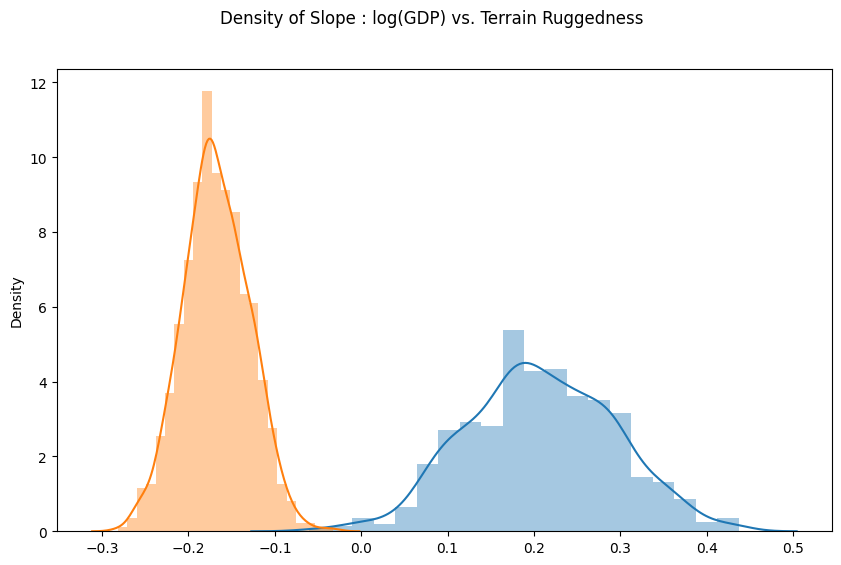

In [18]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");